# Predicting faulty water pumps

# Modelling and Predictions¶

## Import Libraries
Import libraries necessary to for the data cleaning, feature engineering and modeling

In [24]:
import datetime
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
from IPython.display import display  # use of display() for DataFrames
from itertools import compress
import wp_utility as wp_util
import gis_map_viz as gis_map
from water_asset import Water_Asset_Data  

# Import Preprocessing and ML libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, f1_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

%matplotlib inline

In [25]:
# Import libraries used for the deep learning model
import mxnet as mx
import keras
from keras import metrics
from keras import utils
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier    

# Show the deep learning library versions
print ("MXNet version = {}".format(mx.__version__))
print ("Keras version = {}".format(keras.__version__))

MXNet version = 1.2.0
Keras version = 2.2.0


In [26]:
class ModelManager:
    def __init__(self,
                 model_dict={},
                 benchmark_model="",
                 label_names="",
                 num_procs=-1):
        '''creates model dictionary and manager object'''
        print("ModelManager: __init__ ...")

        self.model_dict = model_dict
        self.model_results = {}
        self.benchmark_model = benchmark_model
        self.best_model = None
        self.predictions = None
        self.scoring = f1_score # accuracy_score  # f1_score # 'f1', average=’macro’ #roc_auc # recall_score
        self.test_train_ratio = 0.2  # train and validation set -> 70% 30% 
        self.num_procs = num_procs
        self.label_names = label_names
        print("ModelManager: __init__ Number of models {}".format(len(self.model_dict)))
        self._print_models()

    def _add_model(self, new_model_pair):
        '''add a model to the  manager object  '''
        print("ModelManager: _add_model ...")
        self.model_dict.update(new_model_pair)
        self._print_models()
               
    def _print_models(self):
        '''print the models stored in the model manager object  '''
        for i in self.model_dict:
            print ("****** {} ****** \n {} \n ".format(i,self.model_dict[i]))
    
    def _print_model_scores(self):
        '''print the scores of the modesl eveluated '''
        print("ModelManager: _print_model_scores ...")
        for i in wp_models.model_results:
            print("{} : {:.3f}".format(i, self.model_results[i]))
        fig = plt.figure(figsize=(10, 5))
        plt.bar(self.model_results.keys(), self.model_results.values(), width = 0.7)
        plt.show()

    def _make_scorer(self):
        '''build a custom scorer to evalute models '''
        print("ModelManager: _make_scorer ... {}".format(self.scoring))
        return (make_scorer(self.scoring, average='weighted'))

    def _cross_validate(self, wp_data_instance, k_fold=10):
        '''fold cross validate models on the training dataframe in Water_Asset_Data object '''
        print("ModelManager: _cross_validate ...")

        target_df = wp_data_instance.train_feature_df[wp_data_instance.label_col]
        feature_df = wp_data_instance.train_feature_df.drop(
            [wp_data_instance.id_col, wp_data_instance.label_col], axis=1)
        custom_scorer = self._make_scorer()
        print("ModelManager: _cross_validate feature df shape = {} and target df shape = {}".
            format(feature_df.shape, target_df.shape))

        for model_name, model in self.model_dict.items():
            cv_results = cross_val_score(
                model,feature_df,target_df,cv=k_fold,
                scoring=custom_scorer,n_jobs=self.num_procs)
            self.model_results[model_name] = cv_results.mean()
            print("ModelManager: _cross_validate => {} score for model {}: {:.3f} +/- {:.3f}".format(
                self.scoring, model_name, cv_results.mean(),cv_results.std()))

    def _fit_model(self, model_name, wp_data_instance):
        ''' fit _fit_model model on the train dataframe (train_test_split) in Water_Asset_Data object '''
        print("ModelManager: _fit_model ...")

        target_df = wp_data_instance.train_feature_df[wp_data_instance.label_col]
        feature_df = wp_data_instance.train_feature_df.drop(
            [wp_data_instance.id_col, wp_data_instance.label_col], axis=1)
        model = self.model_dict[model_name]

        # Split the data into a train and a test set
        # stratify param makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify
        X_train, X_test, y_train, y_test = train_test_split(
            feature_df,
            target_df,
            test_size=self.test_train_ratio,
            stratify=target_df,
            shuffle=True)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        cm = confusion_matrix(y_test, predictions)
        np.set_printoptions(precision=2)
        # normalized confusion matrix
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        fit_score = self.scoring(y_test, predictions, average='weighted')
        if model_name not in self.model_results:
            self.model_results[model_name] = fit_score
        
        print("Overall {} Score for model {} = {:.3f}".format(
            self.scoring, model_name,fit_score))
        print("Overall Accuracy Score for model {} = {:.3f}".format(
            model_name, accuracy_score(y_test, predictions)))
        print("Normalized confusion matrix for model {}".format(model_name))
        print(cm)
        print("Classification report for model {}".format(model_name))
        print(classification_report(y_test, predictions))
        
        if hasattr(model, 'feature_importances_'):
            feature_importance = pd.Series(model.feature_importances_,list(X_train)).sort_values(ascending=False).head(20)
            feature_importance.plot(kind='bar', title=(model_name + ': Importance of Features'))

    def _select_best_model(self):
        '''select model with highest score'''
        print("ModelManager: _select_best_model ...")

        best_model_name = max(self.model_results, key=lambda key: self.model_results[key])
        self.best_model = self.model_dict[best_model_name]
        print("ModelManager: _select_best_model - best model is {}".format(best_model_name))
        self._print_model_scores()
        return (best_model_name)

    def _predict(self, wp_data_instance):
        '''generate predictions with best model and data frame parameters'''
        print("ModelManager: _predict ... with model {}".format(self.best_model))
        test_feature_df = wp_data_instance.test_feature_df.drop(wp_data_instance.id_col, axis=1)
        self.predictions = self.best_model.predict(test_feature_df)

        predictions_series = pd.Categorical(pd.Series(self.predictions))
        wp_data_instance.test_feature_df[wp_data_instance.label_col] = predictions_series
        return(self.predictions)
        
    def _get_predictions_df(self, wp_data_instance):
        '''return prediction data frame with index'''
        return(wp_data_instance.test_feature_df[[wp_data_instance.id_col, wp_data_instance.label_col]])

## Load Water Pump Data Object

In [27]:
!dir clean-data\*.pkl

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\Udacity\machine-learning\projects\capstone-project\clean-data

07/28/2018  04:20 PM        15,825,599 clean_wp_data_object.pkl
07/28/2018  03:05 PM        15,823,293 clean_wp_data_object_18072815.pkl
07/28/2018  02:23 PM         3,048,453 clean_wp_test_features_df_18072814.pkl
07/28/2018  03:05 PM         3,048,453 clean_wp_test_features_df_18072815.pkl
07/28/2018  02:23 PM        12,241,432 clean_wp_train_features_df_18072814.pkl
07/28/2018  03:05 PM        12,241,432 clean_wp_train_features_df_18072815.pkl
               6 File(s)     62,228,662 bytes
               0 Dir(s)  1,927,181,295,616 bytes free


In [28]:
filename = 'clean-data/clean_wp_data_object.pkl'
infile = open(filename,'rb')
wp_data = pickle.load(infile)
wp_data.train_feature_df.shape

(59400, 122)

## Create Models, evaluate classification results and select best model

### Create the different tuned models to compare
* We will use a logistic regression as a benchmark model
* we will then use a random forest and, boosted and XG boost  models to evaluate results against the benchmark 

In [29]:
num_procs = -1
k_fold = 5

# Benchmark Model define a pipeline with PCA and logistic regression as our baseline Logistic regression: ovr = one (class) 
# versus rest (of classes)
lr_std_pca = make_pipeline(
    StandardScaler(), PCA(),
    LogisticRegression(multi_class='ovr', class_weight='balanced', n_jobs=num_procs))

# Random Forest ensemble model - previously manually tuned
random_forest = RandomForestClassifier(
    n_estimators=250,
    max_features='sqrt',
    min_samples_split=2,
    max_depth=20,
    min_samples_leaf=1,
    class_weight = 'balanced',
    n_jobs=num_procs)

# GBM ensemble model - previously manually tuned
gradient_boosting = GradientBoostingClassifier(
    criterion='friedman_mse',
    learning_rate=0.1, loss='deviance', max_depth=12,
    min_samples_leaf=1, min_samples_split=2,
    min_weight_fraction_leaf=0.0, n_estimators=200,
    presort='auto', verbose=0)


xg_boosing = XGBClassifier(
 eta = 0.2, booster = "gbtree",
 n_estimators=500,  max_depth=12,
 min_child_weight=1,  gamma=0,
 num_class = 3, objective= 'multi:softmax',
 n_jobs=num_procs,  scale_pos_weight=1)

benchmark_model = 'Logistic Regresstion Std PCA' # 'lr_std_pca'
model_dict = { benchmark_model: lr_std_pca, 
              'Random Forest': random_forest, 
              'Gradient Boosting': gradient_boosting,
              'XG Boost': xg_boosing}

### Create the model manager object which will store the models

In [30]:
wp_models = ModelManager(model_dict=model_dict, benchmark_model=benchmark_model,
                         label_names=wp_data.label_names, num_procs=num_procs)

ModelManager: __init__ ...
ModelManager: __init__ Number of models 4
****** Logistic Regresstion Std PCA ****** 
 Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=1.0, class_weight='balanced', dual=False,...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]) 
 
****** Random Forest ****** 
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=F

### Evaluate models and fit the best performing model

In [31]:
wp_models._cross_validate(wp_data, k_fold=k_fold)

ModelManager: _cross_validate ...
ModelManager: _make_scorer ... <function f1_score at 0x000002781BB01BF8>
ModelManager: _cross_validate feature df shape = (59400, 120) and target df shape = (59400,)
ModelManager: _cross_validate => <function f1_score at 0x000002781BB01BF8> score for model Logistic Regresstion Std PCA: 0.714 +/- 0.003
ModelManager: _cross_validate => <function f1_score at 0x000002781BB01BF8> score for model Random Forest: 0.796 +/- 0.002
ModelManager: _cross_validate => <function f1_score at 0x000002781BB01BF8> score for model Gradient Boosting: 0.800 +/- 0.003
ModelManager: _cross_validate => <function f1_score at 0x000002781BB01BF8> score for model XG Boost: 0.801 +/- 0.001


ModelManager: _select_best_model ...
ModelManager: _select_best_model - best model is XG Boost
ModelManager: _print_model_scores ...
Logistic Regresstion Std PCA : 0.714
Random Forest : 0.796
Gradient Boosting : 0.800
XG Boost : 0.801


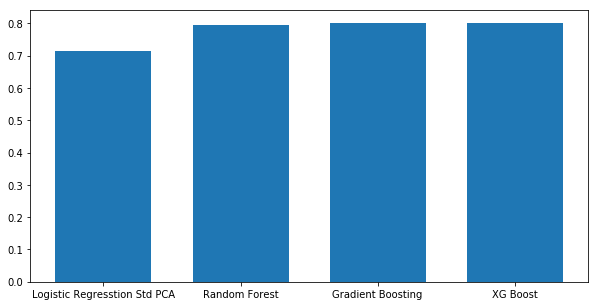

In [32]:
best_model_name = wp_models._select_best_model()

ModelManager: _fit_model ...


C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Overall <function f1_score at 0x000002781BB01BF8> Score for model XG Boost = 0.801
Overall Accuracy Score for model XG Boost = 0.808
Normalized confusion matrix for model XG Boost
[[0.89 0.03 0.09]
 [0.52 0.32 0.16]
 [0.2  0.02 0.79]]
Classification report for model XG Boost
                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6452
functional needs repair       0.53      0.32      0.40       863
         non functional       0.84      0.79      0.81      4565

            avg / total       0.80      0.81      0.80     11880



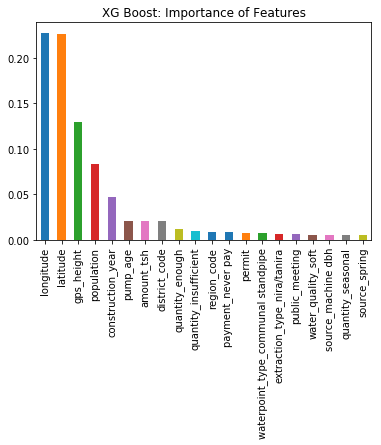

In [33]:
wp_models._fit_model(best_model_name, wp_data)

## Evaluate a Neural Network and compare to the current best model

In [34]:
# create a neural net model - 3 layers, previously tuned
from keras import regularizers
def create_nn_model(input_shape, output_shape):
    print("create_model() with input dim = {} and output dim = {}".format(
        input_shape, output_shape))

    model = Sequential()
    model.add(Dense(64, input_dim=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, input_dim=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, input_dim=input_shape, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(output_shape, activation='softmax'))
    # Compile model, use GPU
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'], context=['gpu(0)'])

    print(model.summary())
    return model

# used the neuralnet hyper parameters previsouly used
input_dim = wp_data.train_feature_df.drop([wp_data.id_col, wp_data.label_col], axis=1).shape[1]
output_dim = wp_data.train_feature_df[wp_data.label_col].nunique()
n_epoch = 100
batch_sz = 16
verbose = 1

# Build a neural net pipeline
nn_model = KerasClassifier(build_fn=create_nn_model, input_shape=input_dim,
                           output_shape=output_dim,  epochs=n_epoch, batch_size=batch_sz, verbose=verbose)

nn_model_pipeline = make_pipeline(StandardScaler(), nn_model)

nn_model_dict = {'nn_model_pipeline': nn_model_pipeline}

In [35]:
# add the neural network model to the ModelManager Object
wp_models._add_model({'nn_model_pipeline':nn_model_pipeline})

ModelManager: _add_model ...
****** Logistic Regresstion Std PCA ****** 
 Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=1.0, class_weight='balanced', dual=False,...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]) 
 
****** Random Forest ****** 
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False) 
 
****** Gradient Boosting ******

In [36]:
wp_models._fit_model('nn_model_pipeline', wp_data)

ModelManager: _fit_model ...
create_model() with input dim = 120 and output dim = 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                7744      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 27        
Total params: 10,115
Trainable params: 10,115
Non-trainabl

C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\mxnet\module\bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0625). Is this intended?
  force_init=force_init)


47520/47520 [==============================] - 25s 534us/step - loss: 0.6834 - acc: 0.7190
Epoch 2/100
47520/47520 [==============================] - 21s 448us/step - loss: 0.6251 - acc: 0.7436
Epoch 3/100
47520/47520 [==============================] - 22s 466us/step - loss: 0.6073 - acc: 0.7493
Epoch 4/100
47520/47520 [==============================] - 22s 455us/step - loss: 0.5966 - acc: 0.7539
Epoch 5/100
47520/47520 [==============================] - 20s 415us/step - loss: 0.5881 - acc: 0.7601
Epoch 6/100
47520/47520 [==============================] - 21s 444us/step - loss: 0.5819 - acc: 0.7613
Epoch 7/100
47520/47520 [==============================] - 21s 443us/step - loss: 0.5758 - acc: 0.7646
Epoch 8/100
47520/47520 [==============================] - 25s 526us/step - loss: 0.5713 - acc: 0.7661
Epoch 9/100
47520/47520 [==============================] - 19s 389us/step - loss: 0.5678 - acc: 0.7675
Epoch 10/100
47520/47520 [==============================] - 20s 416us/step - loss: 0.

Epoch 80/100
47520/47520 [==============================] - 24s 495us/step - loss: 0.5089 - acc: 0.7906
Epoch 81/100
47520/47520 [==============================] - 26s 539us/step - loss: 0.5085 - acc: 0.7888
Epoch 82/100
47520/47520 [==============================] - 30s 626us/step - loss: 0.5090 - acc: 0.7898
Epoch 83/100
47520/47520 [==============================] - 25s 530us/step - loss: 0.5089 - acc: 0.7907
Epoch 84/100
47520/47520 [==============================] - 26s 541us/step - loss: 0.5084 - acc: 0.7894
Epoch 85/100
47520/47520 [==============================] - 20s 426us/step - loss: 0.5059 - acc: 0.7906
Epoch 86/100
47520/47520 [==============================] - 24s 504us/step - loss: 0.5092 - acc: 0.7897
Epoch 87/100
47520/47520 [==============================] - 30s 635us/step - loss: 0.5086 - acc: 0.7896
Epoch 88/100
47520/47520 [==============================] - 27s 563us/step - loss: 0.5072 - acc: 0.7921
Epoch 89/100
47520/47520 [==============================] - 23s 

ModelManager: _select_best_model ...
ModelManager: _select_best_model - best model is XG Boost
ModelManager: _print_model_scores ...
Logistic Regresstion Std PCA : 0.714
Random Forest : 0.796
Gradient Boosting : 0.800
XG Boost : 0.801
nn_model_pipeline : 0.768


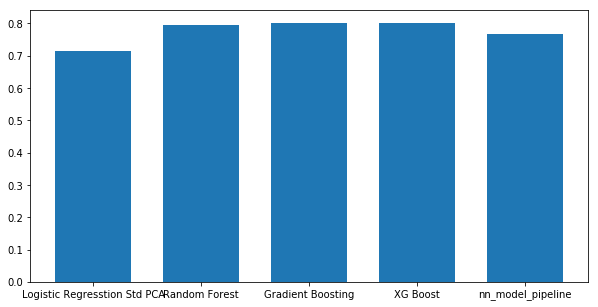

In [37]:
best_model_name = wp_models._select_best_model()

## Generate and submit predictions performed by the best performing model on the test data set

In [38]:
predicitions = wp_models._predict(wp_data)
len(predicitions)

ModelManager: _predict ... with model XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=12, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=-1, nthread=None, num_class=3,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)


C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


14850

### Review and submit our predictions to datadriven.org

In [39]:
# def _get_predictions_df(self, label_df, label_id, label_col):
prediction_df = wp_models._get_predictions_df(wp_data_instance = wp_data)
prediction_df.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


#### Visualize the test set predicted labels

C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\mpl_toolkits\basemap\__init__.py:1303: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  b = np.array(np.fromstring(polystring,dtype='<f4'),'f8')


GIS_Map_Viz: __init__ ... v2
GIS_Map_Viz: _display_gps_map ...


C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Chris Cochet\Anaconda3\envs\Python3.6_ScikitLearn_MxNet\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


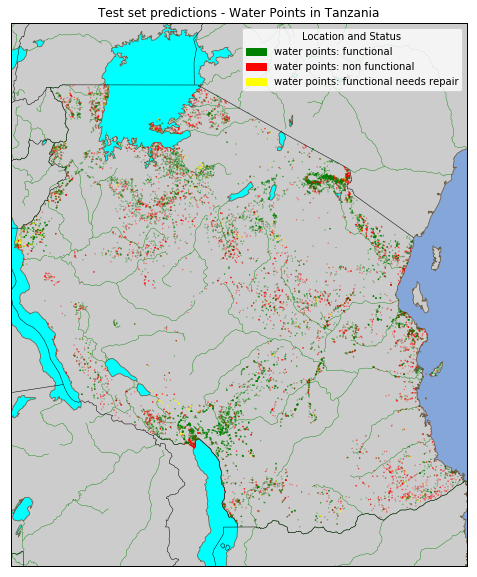

In [40]:
# feature names to be mapped
gps_map_features = ['latitude', 'longitude']

# create a map object
wp_map = gis_map.GIS_Map_Viz(latitude_feature_name = gps_map_features[0], longitude_feature_name = gps_map_features[1],
                             gps_bounderies_dict = wp_data.gps_bounderies_dict)

#Display the test set color coded water points
wp_map._display_gps_map(wp_data.test_feature_df, prediction_df[wp_data.label_col],
                         "Test set predictions - Water Points in Tanzania")

In [41]:
prediction_df.shape

(14850, 2)

#### Submit the predictions: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/submissions/

In [42]:
sumbission_data_dir = 'prediction-data\\'
submission_file = sumbission_data_dir  + 'pump_predictions_submission_df.csv'

prediction_df.to_csv(submission_file, index=False)

In [43]:
!dir $sumbission_data_dir

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\Udacity\machine-learning\projects\capstone-project\prediction-data

07/03/2018  08:24 PM    <DIR>          .
07/03/2018  08:24 PM    <DIR>          ..
08/05/2018  07:11 PM           294,488 pump_predictions_submission_df.csv
               1 File(s)        294,488 bytes
               2 Dir(s)  1,927,181,582,336 bytes free
